# Continuous vs. Discrete State-Space

Philipp Schlatter, LSTM FAU, 2025

Run in Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/UA/cont_vs_discrete.ipynb

This notebook demonstrates the conversion and comparison between:
1.  **Continuous-Time (CT)**: $\dot{\mathbf{x}}(t) = A\mathbf{x}(t) + B\mathbf{u}(t)$
2.  **Discrete-Time (DT)**: $\mathbf{x}_{k} = A_d\mathbf{x}_{k-1} + B_d\mathbf{u}_{k-1}$
3.  **Output**: $y(t) = C\mathbf{x}(t) + D\mathbf{u}(t) $

We will use a **Damped Harmonic Oscillator** (Mass-Spring-Damper) as our example system.

**Discretization Method:** Zero-Order Hold (ZOH)
$$ A_d = e^{AT_s} $$
$$ B_d = \left( \int_0^{T_s} e^{A\tau} B d\tau \right)  $$
$$ C_d = C $$
$$ D_d = D $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import expm
from numpy.linalg import pinv,eig

In [2]:
# Define Physical Parameters (Mass-Spring-Damper)
m = 1.0   # Mass (kg)
k = 2.0   # Stiffness (N/m)
c = 0.5   # Damping (N-s/m)

# Define Continuous-Time (CT) Matrices
# State: x1 = position, x2 = velocity
# dx1/dt = x2
# dx2/dt = -(k/m)x1 - (c/m)x2 + (1/m)u

A_ct = np.array([[0, 1],
                 [-k/m, -c/m]])

B_ct = np.array([[0],
                 [1/m]])

C_ct = np.array([[1, 0]])  # We measure position
D_ct = np.array([[0]])

print("Continuous System Matrix A:")
print(A_ct)
print("Continuous System Matrix B:")
print(B_ct)

Continuous System Matrix A:
[[ 0.   1. ]
 [-2.  -0.5]]
Continuous System Matrix B:
[[0.]
 [1.]]


In [3]:
# Discretize the System
Ts = 0.5  # Sampling Time in seconds (try changing this to 0.1 or 1.0)

# Method 1: Using Scipy's convenience function (Recommended)
# method='zoh' assumes input is held constant between samples
sys_ct = signal.StateSpace(A_ct, B_ct, C_ct, D_ct)
sys_dt = sys_ct.to_discrete(dt=Ts, method='zoh')

A_dt = sys_dt.A
B_dt = sys_dt.B
C_dt = sys_dt.C
D_dt = sys_dt.D

print(f"\nSampling Time Ts: {Ts}s")
print("Discrete System Matrix A_d:")
print(np.round(A_dt, 4))
print("Discrete System Matrix B_d:")
print(np.round(B_dt, 4))


Sampling Time Ts: 0.5s
Discrete System Matrix A_d:
[[ 0.7789  0.4065]
 [-0.813   0.5756]]
Discrete System Matrix B_d:
[[0.1106]
 [0.4065]]


In [4]:
# Method 2: Manual Calculation (For educational verification)
A_manual = expm(A_ct * Ts)
B_manual = np.dot(np.linalg.inv(A_ct), np.dot((A_manual - np.eye(2)), B_ct))
print("Discrete System Matrix A_d (manual):")
print(np.round(A_dt, 4))
print("Discrete System Matrix B_d (manual):")
print(np.round(B_dt, 4))

Discrete System Matrix A_d (manual):
[[ 0.7789  0.4065]
 [-0.813   0.5756]]
Discrete System Matrix B_d (manual):
[[0.1106]
 [0.4065]]


--- Stability Check ---
Continuous Eigenvalues: [-0.25+1.392j -0.25-1.392j]
CT Stable (Re < 0)? True

Discrete Eigenvalues:   [0.677+0.566j 0.677-0.566j]
DT Stable (|z| < 1)?  True


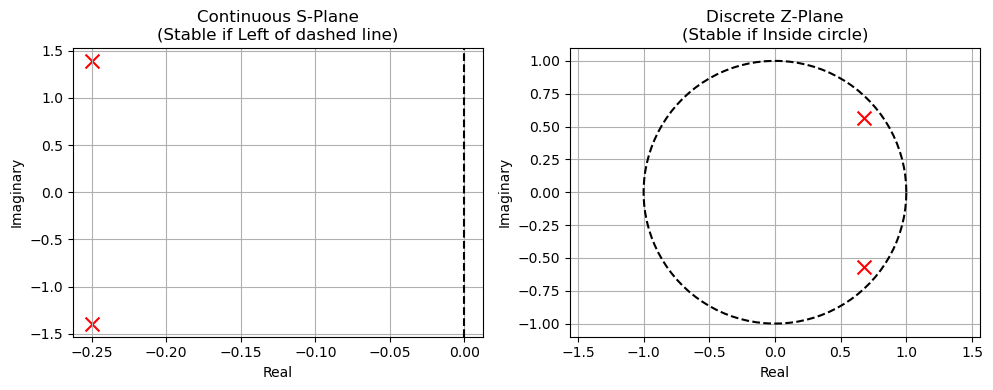

In [5]:
# Stability Analysis
# Calculate Eigenvalues
eig_ct = np.linalg.eigvals(A_ct)
eig_dt = np.linalg.eigvals(A_dt)

print("--- Stability Check ---")
print(f"Continuous Eigenvalues: {np.round(eig_ct, 3)}")
is_stable_ct = np.all(np.real(eig_ct) < 0)
print(f"CT Stable (Re < 0)? {is_stable_ct}")

print(f"\nDiscrete Eigenvalues:   {np.round(eig_dt, 3)}")
is_stable_dt = np.all(np.abs(eig_dt) < 1)
print(f"DT Stable (|z| < 1)?  {is_stable_dt}")

# Visualization of Poles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# CT Plot
ax1.scatter(np.real(eig_ct), np.imag(eig_ct), marker='x', s=100, c='r')
ax1.axvline(0, color='k', linestyle='--')
ax1.set_title('Continuous S-Plane\n(Stable if Left of dashed line)')
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginary')
ax1.grid(True)

# DT Plot
theta = np.linspace(0, 2*np.pi, 100)
ax2.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle')
ax2.scatter(np.real(eig_dt), np.imag(eig_dt), marker='x', s=100, c='r')
ax2.set_title('Discrete Z-Plane\n(Stable if Inside circle)')
ax2.set_xlabel('Real')
ax2.set_ylabel('Imaginary')
ax2.grid(True)
ax2.axis('equal')

plt.tight_layout()
plt.show()

In [6]:
print("Eigenvalues from matrices")
eig_ct, eig_dt

Eigenvalues from matrices


(array([-0.25+1.39194109j, -0.25-1.39194109j]),
 array([0.6772562+0.56579574j, 0.6772562-0.56579574j]))

In [7]:
print("Eigenvalues transformed from either CT or DT")
np.log(eig_dt)/Ts, np.exp(eig_ct*Ts) 

Eigenvalues transformed from either CT or DT


(array([-0.25+1.39194109j, -0.25-1.39194109j]),
 array([0.6772562+0.56579574j, 0.6772562-0.56579574j]))

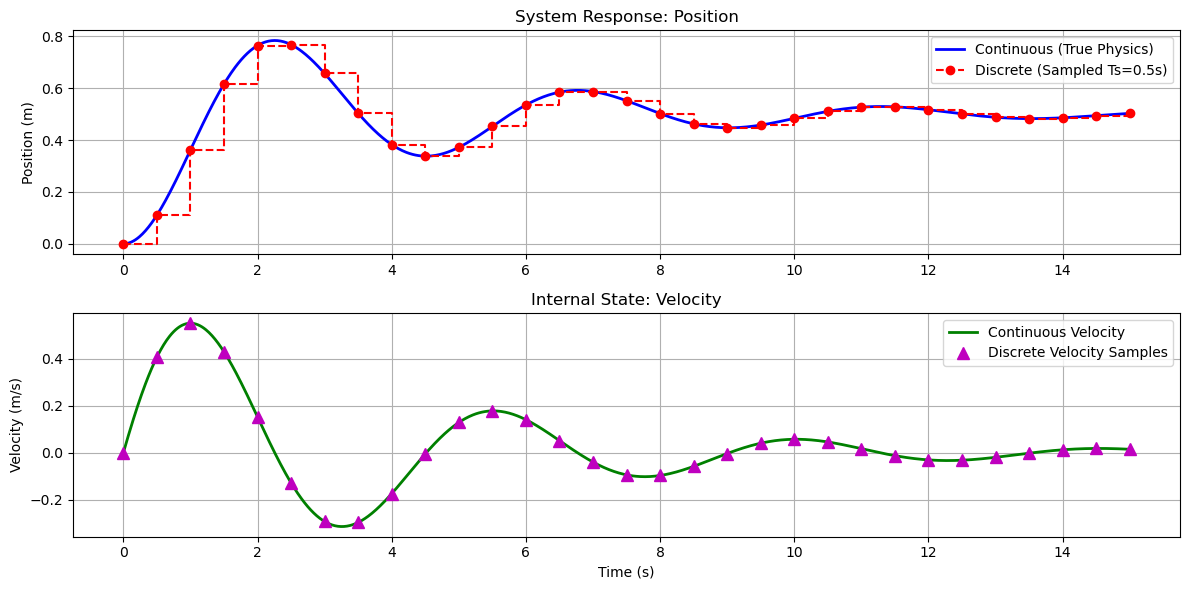

In [8]:
# imulation

# Define Time Horizon
T_final = 15.0
t_continuous = np.linspace(0, T_final, 1000) # High resolution for smooth lines
t_discrete = np.arange(0, T_final + Ts, Ts)  # Low resolution for steps

# Define Input (Step Input of magnitude 1.0)
u_continuous = np.ones_like(t_continuous)
u_discrete = np.ones_like(t_discrete)

# Simulate Continuous
# lsim performs the integration of the differential equations
_, y_ct, x_ct = signal.lsim(sys_ct, U=u_continuous, T=t_continuous)

# Simulate Discrete
# dlsim performs the matrix multiplication steps
_, y_dt, x_dt = signal.dlsim(sys_dt, u=u_discrete, t=t_discrete)

# Plotting Results
plt.figure(figsize=(12, 6))

# Plot Position (Output)
plt.subplot(2, 1, 1)
plt.plot(t_continuous, y_ct, 'b-', linewidth=2, label='Continuous (True Physics)')
plt.step(t_discrete, y_dt, 'r--o', where='post', label=f'Discrete (Sampled Ts={Ts}s)')
plt.title('System Response: Position')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)

# Plot Velocity (Internal State)
plt.subplot(2, 1, 2)
plt.plot(t_continuous, x_ct[:, 1], 'g-', linewidth=2, label='Continuous Velocity')
plt.plot(t_discrete, x_dt[:, 1], 'm^', markersize=8, label='Discrete Velocity Samples')
plt.title('Internal State: Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Dynamic Mode decomposition

#### 1. Free response system

--- DMD Verification ---
True Discrete Eigenvalues: [0.6773+0.5658j 0.6773-0.5658j]
DMD Derived Eigenvalues:   [0.6773+0.5658j 0.6773-0.5658j]


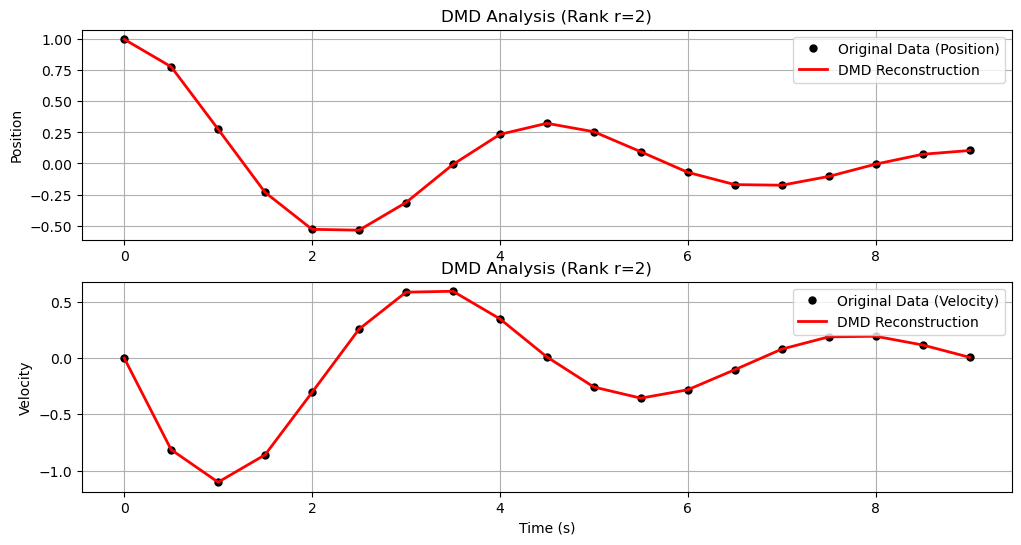

In [9]:
# --- DMD ANALYSIS ---

# Generate Unforced Data (Free Response) for DMD
# DMD works best on autonomous systems (x_k+1 = A * x_k)
# We simulate the system starting at x0=[1, 0] with u=0
t_dmd = np.arange(0, 10, Ts)
u_dmd = np.zeros_like(t_dmd)
x0 = [1.0, 0.0] # Initial stretch, release
_, _, x_data = signal.dlsim(sys_dt, u=u_dmd, t=t_dmd, x0=x0)

# Prepare Data Matrices (Transpose so rows=states, cols=time)
# X represents x[k], X_prime represents x[k+1]
data = x_data.T
X = data[:, :-1]
X_prime = data[:, 1:]

#------------------------
# Either just use the pseudo-inverse:
Xdag = pinv(X)
A_pseudo=X_prime@Xdag
r = 2
A_tilde = []

#==============================
# or the actual DMD algorithm using SVD:
# Perform SVD
# X approx U * Sigma * V_trans
#r = 2 # Rank (we know we have 2 states)
#U, S, Vh = np.linalg.svd(X, full_matrices=False)

# Truncate (though here our system is already low rank)
#Ur = U[:, :r]
#Sr = S[:r]
#Vr = Vh[:r, :].conj().T 

# Compute A_tilde (The low-dimensional dynamics)
# A_tilde = U' * X' * V * Sigma_inv
#A_tilde = Ur.T.conj() @ X_prime @ Vr @ np.diag(1.0 / Sr)
# This is using full matrices (essentially pinv but using svd)
#A_dmd = X_prime @ Vh.T @ ( np.diag(1.0 / S) ) @ U.T

#------------------------------

# Eigen-decomposition
#lam_dmd, W = eig(A_tilde)

# Reconstruct Continuous Eigenvalues (to compare with Physics)
# omega = ln(lambda) / dt
#omega_dmd = np.log(lam_dmd) / Ts

# Compute DMD Modes (Phi)
# Maps low-dim eigenvectors W back to high-dim space
#Phi = X_prime @ Vr @ np.diag(1.0 / Sr) @ W

# if you want to do it using full matrices (either A_pseudo or A_dt)
lam_dmd, Phi = eig(A_pseudo)
omega_dmd = np.log(lam_dmd) / Ts

# Reconstruction of the signal
# b = Phi_pseudo_inv * x[0]
b = np.linalg.pinv(Phi) @ X[:, 0]

# Time evolution
time_steps = X.shape[1]
x_reconstructed = np.zeros((2, time_steps), dtype=complex)

for kk in range(time_steps):
    # Sum( b_j * Phi_j * lambda_j^k )
    for j in range(r):
        x_reconstructed[:, kk] += b[j] * Phi[:, j] * (lam_dmd[j]**kk)

# --- VISUALIZATION & VERIFICATION ---
print("--- DMD Verification ---")
print(f"True Discrete Eigenvalues: {np.round(eig_dt, 4)}")
print(f"DMD Derived Eigenvalues:   {np.round(lam_dmd, 4)}")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_dmd[:-1], X[0, :], 'ko', label='Original Data (Position)', markersize=5)
plt.plot(t_dmd[:-1], np.real(x_reconstructed[0, :]), 'r-', linewidth=2, label='DMD Reconstruction')
plt.title(f'DMD Analysis (Rank r={r})')
#plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_dmd[:-1], X[1, :], 'ko', label='Original Data (Velocity)', markersize=5)
plt.plot(t_dmd[:-1], np.real(x_reconstructed[1, :]), 'r-', linewidth=2, label='DMD Reconstruction')
plt.title(f'DMD Analysis (Rank r={r})')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.legend()
plt.grid(True)

plt.show()

In [10]:
print("Compare the DMD algorithm (svd), the pseudo-inverse, and the original system")
A_tilde, A_pseudo, A_dt

Compare the DMD algorithm (svd), the pseudo-inverse, and the original system


([],
 array([[ 0.77887612,  0.40647966],
        [-0.81295932,  0.57563629]]),
 array([[ 0.77887612,  0.40647966],
        [-0.81295932,  0.57563629]]))

In [11]:
#print("Compare the full DMD modes")
#X_prime @ Vh.conj().T @ np.linalg.inv(np.diag(S)) @ W, Phi

In [12]:
omega0 = np.sqrt(k/m)
zeta = c/2/np.sqrt(m*k)
print("Original parameters of the system (omega0 and zeta)")
omega0,zeta

Original parameters of the system (omega0 and zeta)


(1.4142135623730951, 0.17677669529663687)

In [13]:
# extraced parameters
lam_ct = np.log(lam_dmd)/Ts
lam = lam_ct.real[0]
omega1 = lam_ct.imag[0]

zz=np.sqrt(1/(  (omega1/lam)**2  +1))
w00 = -lam/zz

print("Parameters discovered by DMD")
w00,zz

Parameters discovered by DMD


(1.4142135623730954, 0.17677669529663667)

#### 2. Response with constant input u

This is if you know B and u. To be done.

#### 3. Response with general input u (DMDc)

Shape of X: (2, 19)
Shape of Upsilon: (1, 19)
Shape of Omega (Augmented): (3, 19)

--- DMDc Matrix Comparison ---
True Discrete A:
 [[ 0.7789  0.4065]
 [-0.813   0.5756]]
DMDc Extracted A:
 [[ 0.7789  0.4065]
 [-0.813   0.5756]]

True Discrete B:
 [[0.1106]
 [0.4065]]
DMDc Extracted B:
 [[0.1106]
 [0.4065]]


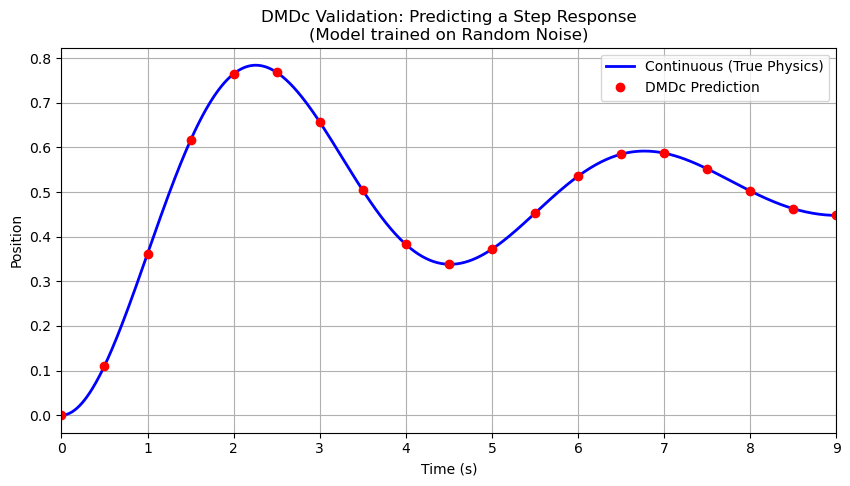

In [14]:
# --- DMDc ANALYSIS ---

# Generate Training Data with Rich Input
# To identify B properly, we need to "excite" the system.
# We use random noise as input to ensure we see various dynamics.
t_train = np.arange(0, 10, Ts)
u_train = np.random.randn(len(t_train)) # Random forcing
#u_train = np.ones_like(t_train) # unit forcing, also works
_, _, x_train_data = signal.dlsim(sys_dt, u=u_train, t=t_train, x0=[0,0])

# Organize Snapshots
data = x_train_data.T               # Shape: (2, m)
input_data = u_train.reshape(1, -1) # Shape: (1, m)

# Standard DMD definitions
X = data[:, :-1]              # States x[k]
X_prime = data[:, 1:]         # States x[k+1]
Upsilon = input_data[:, :-1]  # Inputs u[k]

# Create the Augmented Matrix Omega
# We stack X and Upsilon on top of each other
Omega = np.vstack((X, Upsilon))

print(f"Shape of X: {X.shape}")
print(f"Shape of Upsilon: {Upsilon.shape}")
print(f"Shape of Omega (Augmented): {Omega.shape}")

# Perform SVD on the Augmented Matrix Omega
# Omega = U_tilde * S_tilde * V_tilde_trans
U_til, S_til, Vh_til = np.linalg.svd(Omega, full_matrices=False)

# Compute the Operator G = [A, B]
# G = X_prime * V_tilde * S_tilde_inv * U_tilde_trans
# (This effectively solves X' = G * Omega via pseudo-inverse)
S_til_inv = np.diag(1.0 / S_til)
G = X_prime @ Vh_til.T @ S_til_inv @ U_til.T

# Extract A and B from G
# G has shape (n, n + p) where n=states, p=inputs
n = X.shape[0]
A_dmdc = G[:, :n]
B_dmdc = G[:, n:]

# --- VERIFICATION WITH A NEW TEST CASE ---

print("\n--- DMDc Matrix Comparison ---")
print("True Discrete A:\n", np.round(A_dt, 4))
print("DMDc Extracted A:\n", np.round(A_dmdc, 4))

print("\nTrue Discrete B:\n", np.round(B_dt, 4))
print("DMDc Extracted B:\n", np.round(B_dmdc, 4))

# Verify by simulating a STEP response (different from the random training input)
t_test = np.arange(0, 10, Ts)
u_test = np.ones_like(t_test) * 1.0 # Step input

# True Physics Simulation
_, y_true, _ = signal.dlsim(sys_dt, u=u_test, t=t_test)

# Reconstruction using extracted DMDc matrices
# We manually step through x[k+1] = A_dmdc * x[k] + B_dmdc * u[k]
x_dmdc = np.zeros((2, len(t_test)))
x_curr = np.zeros((2, 1)) # Start at zero

for k in range(len(t_test)-1):
    x_dmdc[:, k] = x_curr.flatten()
    # The DMDc Equation:
    u_k = u_test[k].reshape(1,1)
    x_next = A_dmdc @ x_curr + B_dmdc @ u_k
    x_curr = x_next
x_dmdc[:, -1] = x_curr.flatten()

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(t_continuous, y_ct, 'b-', linewidth=2, label='Continuous (True Physics)')
#plt.plot(t_test, y_true, 'b-', linewidth=2, label='True System (Step Response)')
plt.plot(t_test, x_dmdc[0, :], 'ro', linewidth=2, label='DMDc Prediction')
plt.title('DMDc Validation: Predicting a Step Response\n(Model trained on Random Noise)')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.xlim(0,9)
plt.legend()
plt.grid(True)
plt.show()